# COVID-19 Data Analysis and Forecasting

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney/Tweet_Analysis

## Introduction

### Problem and Purpose

#### This project will use forecasting to model Covid-19 deaths  based on current hospitalization, ventilator, and death data. I will be using API html links to bring in up to date data regularly. This project will use supervised learning in the form of ARIMA and SARIMAX in order to create time series death forecasts.

#### The purpose of this analysis is to provide an accurate forecast of Covid-19 related deaths as 2021 progresses.
#### Our challenges are -
#### * 1. Create multiple forecasts by creating forecasts for specific states
#### * 2. Build a forecast for the United States as a whole
#### * 3. Provide insights as to the urgency of making changes to how we are operating as a country

## Table of Contents

### Standard Libraries

In [322]:
from tensorflow.random import set_seed
import numpy as np

set_seed(42)
np.random.seed(42)

In [323]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
%matplotlib inline
import functools
from jupyter_plotly_dash import JupyterDash
import datetime as dt
from datetime import date
from datetime import datetime, timedelta
import pandas_datareader as pdr
import holidays
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output,State
# app = JupyterDash('our app')
# # pio.templates
# import plotly.express as px
# import plotly.io as pio

In [324]:
# import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, TensorBoard

In [325]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [326]:
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

In [327]:
import warnings
warnings.filterwarnings('ignore')

### Custom Libraries

In [391]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from Cust_Func import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explore Data

### Create New DataFrame

In [329]:
open_links = False

In [330]:
import webbrowser

if open_links == True:
    webbrowser.open("https://covidtracking.com/")
    webbrowser.open("https://covidtracking.com/data/api")

#### The Covid Tracking Project was organized by the news agency The Atlantic early in 2020 in an effort to provide as much data on the pandemic as possible. Coordination of state by state Covid data required building working relationships with state officials to obtain relevant state information. Above are links to the project that can provide further information regarding Covid-19. Additionally, it is worth noting that the project is coming to its end at the beginning of March 2021 as a result of improvements to Federal collection of data. 

In [412]:
# set to true to fetch new data
get_data = True

In [413]:
if get_data == True:
    df_states = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv',index_col='date',parse_dates=True)
    df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)
    df_states.to_csv('StateData.csv')
    df_whole_US.to_csv('USA.csv')
else:
    df_states = pd.read_csv('StateData.csv', index_col='date', parse_dates=True)
    df_whole_US = pd.read_csv('USA.csv', index_col='date', parse_dates=True)

In [414]:
df_states.head()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2021-02-10,AK,53991.0,NaN,NaN,NaN,totalTestsViral,1568003.0,34.0,1224.0,NaN,...,53991,0,1,baf68d880d4bd467802c16dcd7b66d8a228e6137,0,0,0,0,0,NaN
2021-02-10,AL,476067.0,102466.0,1830673.0,NaN,totalTestsPeopleViral,2204274.0,1401.0,43685.0,NaN,...,2306740,309,186,0daf535b515ad0db70e0dd283dbc5b236218df21,0,0,0,0,0,NaN
2021-02-10,AR,309940.0,64075.0,2306389.0,NaN,totalTestsViral,2552254.0,735.0,14211.0,283.0,...,2616329,26,37,7bc38ff5f537b736cba8b490100e49387dc29045,0,0,0,0,0,NaN
2021-02-10,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,NaN,...,2140,0,0,f2b562c1317d5a2b5e6b546f5e8d12a1937bcf8f,0,0,0,0,0,NaN
2021-02-10,AZ,789245.0,52525.0,2841495.0,NaN,totalTestsViral,7061776.0,2589.0,55088.0,763.0,...,3630740,176,121,94f1c11ee26d099f1b29e910fc17ec21627f0331,0,0,0,0,0,NaN


In [334]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19317 entries, 2021-02-09 to 2020-01-13
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        19317 non-null  object 
 1   positive                     19128 non-null  float64
 2   probableCases                8282 non-null   float64
 3   negative                     15379 non-null  float64
 4   pending                      2009 non-null   float64
 5   totalTestResultsSource       19317 non-null  object 
 6   totalTestResults             19215 non-null  float64
 7   hospitalizedCurrently        15960 non-null  float64
 8   hospitalizedCumulative       11903 non-null  float64
 9   inIcuCurrently               10442 non-null  float64
 10  inIcuCumulative              3480 non-null   float64
 11  onVentilatorCurrently        8290 non-null   float64
 12  onVentilatorCumulative       1189 non-null   float64
 13 

In [335]:
df_whole_US.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
date,,,,,,,,,,,,,,,,,,,,,
2021-02-09,56,26968049.0,125324107.0,10516.0,79179.0,831088.0,16129.0,43000.0,5216.0,4092.0,...,2021-02-09T24:00:00Z,NaN,0,0,2795,3144,544215,92986,1611368,acb0551c7e583fceb1c856f410ec6fb9ffe7499d
2021-02-08,56,26875063.0,124779892.0,12114.0,80055.0,827944.0,16174.0,42833.0,5260.0,4080.0,...,2021-02-08T24:00:00Z,NaN,0,0,1309,1638,4866739,77737,1434298,fe5eb3c282fee2b8fa0cacce8bc9497711b286db
2021-02-07,56,26797326.0,119913153.0,12061.0,81439.0,826306.0,16616.0,42779.0,5342.0,4079.0,...,2021-02-07T24:00:00Z,NaN,0,0,1475,1543,393480,95994,1498467,652854f6dbc5adcea89dd9eb3338eba0c155b458
2021-02-06,56,26701332.0,119519673.0,12070.0,84233.0,824763.0,17093.0,42730.0,5475.0,4078.0,...,2021-02-06T24:00:00Z,NaN,0,0,2994,2443,518729,114557,1881694,049e3795a89dd7b777094aaecc923ed916ea3aee
2021-02-05,56,26586775.0,119000944.0,11546.0,86373.0,822320.0,17284.0,42626.0,5596.0,4060.0,...,2021-02-05T24:00:00Z,NaN,0,0,3543,2940,595505,131146,1879114,ea7540de670c42935d25446d48c71a2c399f58b0


### Plot of Ventilators and Deaths for Each State

In [336]:
df_states.columns.unique

<bound method Index.unique of Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestRe

In [337]:
df_states.isnull().sum()

state                              0
positive                         189
probableCases                  11035
negative                        3938
pending                        17308
totalTestResultsSource             0
totalTestResults                 102
hospitalizedCurrently           3357
hospitalizedCumulative          7414
inIcuCurrently                  8875
inIcuCumulative                15837
onVentilatorCurrently          11027
onVentilatorCumulative         18128
recovered                       5457
dataQualityGrade                1334
lastUpdateEt                     583
dateModified                     583
checkTimeEt                      583
death                            871
hospitalized                    7414
dateChecked                      583
totalTestsViral                 6532
positiveTestsViral             11893
negativeTestsViral             14870
positiveCasesViral              5775
deathConfirmed                 10330
deathProbable                  12446
t

In [338]:
# columns to keep in dataframe
columns = ['state','death','inIcuCurrently','onVentilatorCurrently','positive','hospitalizedCurrently','deathIncrease']

In [339]:
for col in columns:
    df_states[col] = df_states[col].fillna(0)

In [340]:
df_states = sort_and_clean_df(dataframe=df_states, target_columns=columns, percent_data_threshold=.05)

In [341]:
df_states.iloc[:50].sort_values(by='death',ascending=False) # only graph the top 7 
# that keep state ventilator data

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2021-02-09,CA,44477.0,3264.0,0.0,3354591.0,11904.0,327
2021-02-09,TX,39001.0,2777.0,0.0,2504556.0,9401.0,301
2021-02-09,NY,36481.0,1412.0,971.0,1487086.0,7875.0,142
2021-02-09,FL,28526.0,0.0,0.0,1758254.0,5307.0,239
2021-02-09,PA,22620.0,574.0,304.0,876913.0,2890.0,149
2021-02-09,NJ,22103.0,544.0,360.0,728304.0,2827.0,92
2021-02-09,IL,21802.0,497.0,240.0,1150170.0,2117.0,23
2021-02-09,MI,15925.0,299.0,149.0,623731.0,1175.0,62
2021-02-09,GA,15301.0,0.0,0.0,947416.0,3689.0,171


In [342]:
df_states['state'].unique() # list of states to iterate through

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [343]:
# list of unique state postal codes
# state_postal = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
#        'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
#        'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
#        'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
#        'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
#        'WY']

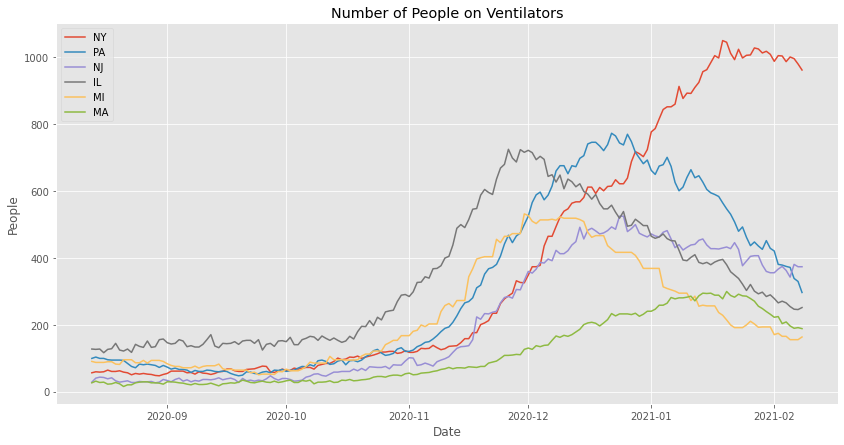

In [344]:
# for loop iterates through shortened list and prints ventilator usage
# for the trailing 180 day period. 
state_postal = ['NY', 'PA', 'NJ','IL','MI','MA']

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state]['onVentilatorCurrently'].sort_index()
    df_plot = df_individual.iloc[(df_individual.index.argmax()-180):(df_individual.index.argmax())]
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of People on Ventilators')
    plt.xlabel('Date')
    plt.ylabel('People')
    plt.legend();

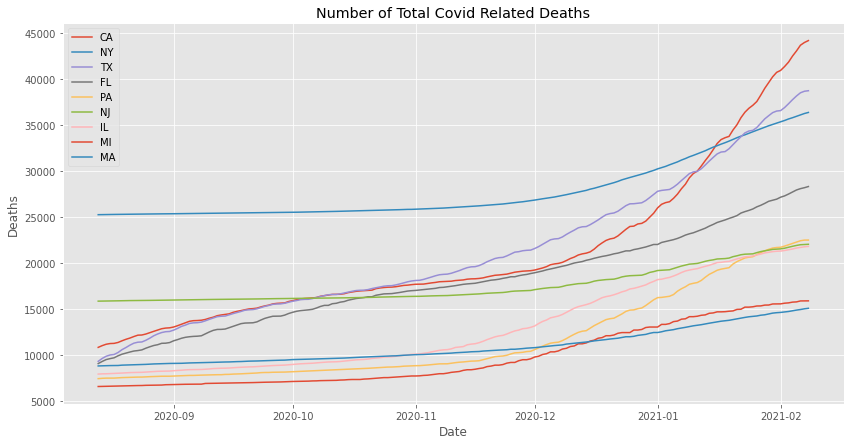

In [345]:
# same as above graph - all states have death data, this is a graph of the
# states with the highest covid mortality 
state_postal = ['CA', 'NY', 'TX', 'FL', 'PA', 'NJ','IL','MI','MA'] # highest death count states
# some do not have ventilator data reported. 

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state].death.sort_index()
    df_plot = df_individual.iloc[(df_individual.index.argmax()-180):(df_individual.index.argmax())]
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of Total Covid Related Deaths')
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.legend();

### Plot Alaska Death Count

In [346]:
df_AK = df_states[df_states['state']=='AK'] # just look at Alaska for now

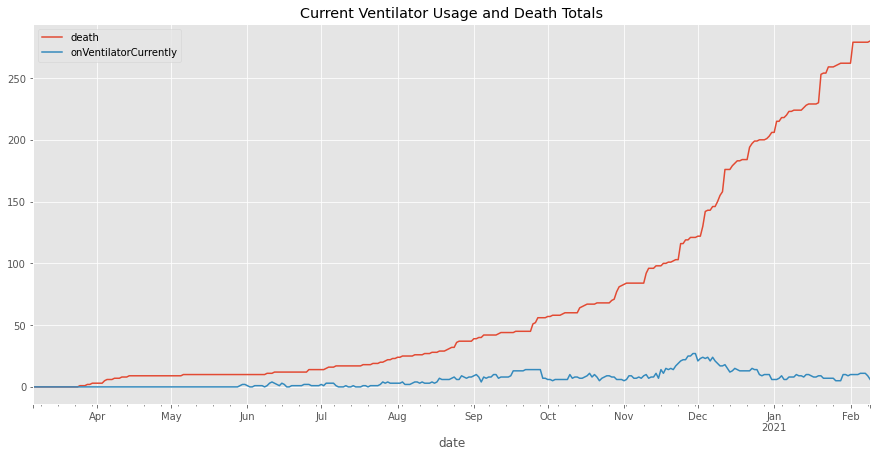

In [347]:
fig = plt.figure(figsize=(15,7));

df_AK['death'].plot(legend=True,title='Current Ventilator Usage and Death Totals');
df_AK['onVentilatorCurrently'].plot(legend=True);

# Modeling and Forecasts

## SARIMAX Modeling

### NY State

#### NY State was one of the first states to experience the worst of the pandemic. In addition to this, they are one of the most populous states in the country, and have had a spike in Covid cases post-holidays.

In [417]:
df = state_dataframe(df_states, 'NY')

TypeError: 'DataFrame' object is not callable

In [ ]:
df_ref = state_dataframe(df_states, 'NY')

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 2020-03-02 to 2021-02-09
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  345 non-null    object 
 1   death                  345 non-null    float64
 2   inIcuCurrently         345 non-null    float64
 3   onVentilatorCurrently  345 non-null    float64
 4   positive               345 non-null    float64
 5   hospitalizedCurrently  345 non-null    float64
 6   deathIncrease          345 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 21.6+ KB


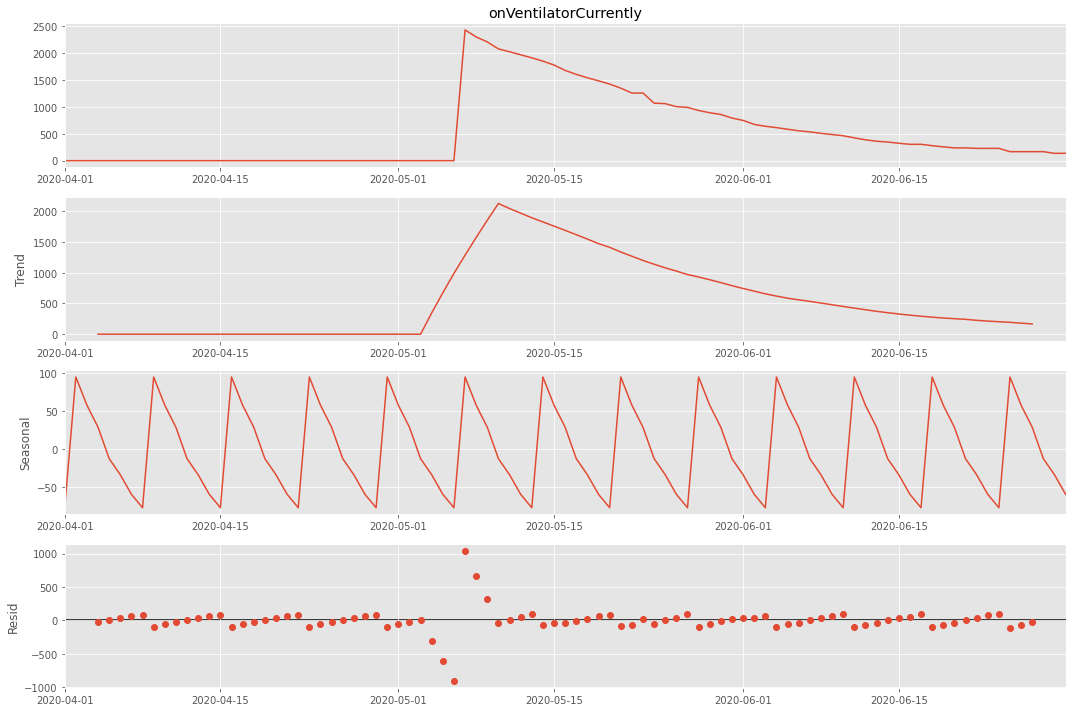

In [351]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['onVentilatorCurrently']).plot();

ARIMA order is:  (5, 2, 5)
Seasonal ARIMA order is:  (0, 0, 0, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     onVentilatorCurrently   No. Observations:                  240
Model:                  SARIMAX(5, 2, 5)   Log Likelihood                -910.945
Date:                   Wed, 10 Feb 2021   AIC                           1843.890
Time:                           15:10:10   BIC                           1881.804
Sample:                       05-16-2020   HQIC                          1859.180
                            - 01-10-2021                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8916      0.264     -7.167      0.000      -2.409      -1.374
ar.L2         -1.5966      0.594     -2.689      0.007      -2.760      -0.433
ar.L3         -0.7322      0.586     -1.249      0.212      -1.881       0.417
ar.L4         -0.0857      0.313     -0.274      0.784      -0.699       0.528
ar.L5          0.0902      0.087      1.040      0.298      -0.080       0.260
ma.L1          1.0590      0.272      3.897      0.000       0.526       1.592
ma.L2         -0.0323      0.384     -0.084      0.933      -0.784       0.720
ma.L3         -0.6685      0.108     -6.189      0.000      -0.880      -0.457
ma.L4         -0.3150      0.232     -1.357      0.175      -0.770       0.140
ma.L5          0.1426      0.176      0.812      0.417      -0.202       0.487
sigma2       159.5178      9.560     16.687      0.000     140.781     178.254
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               210.58
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.13
Prob(H) (two-sided):                  0.47   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

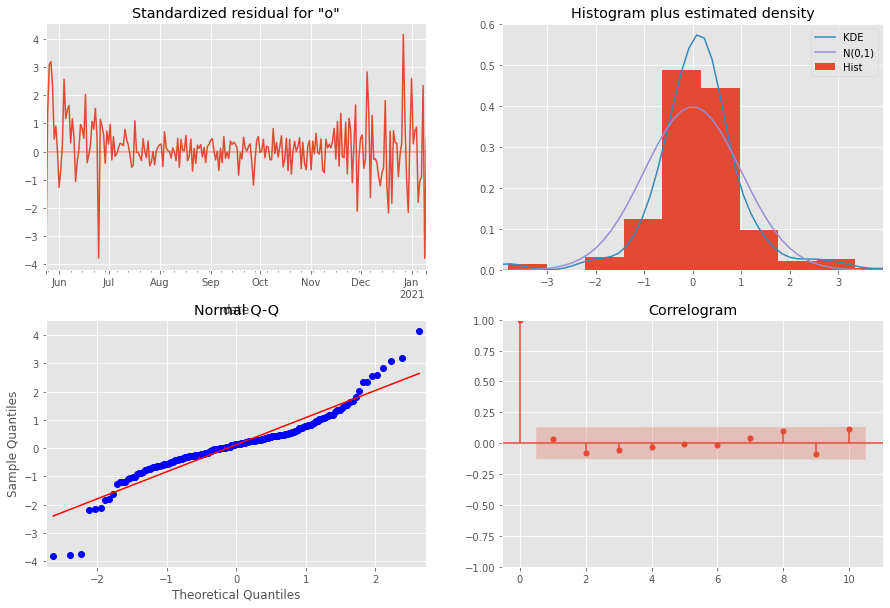

In [352]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'onVentilatorCurrently', days_to_forecast=30, m_periods=6, verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details

#### The ends of the q-q plot are not quite in line.

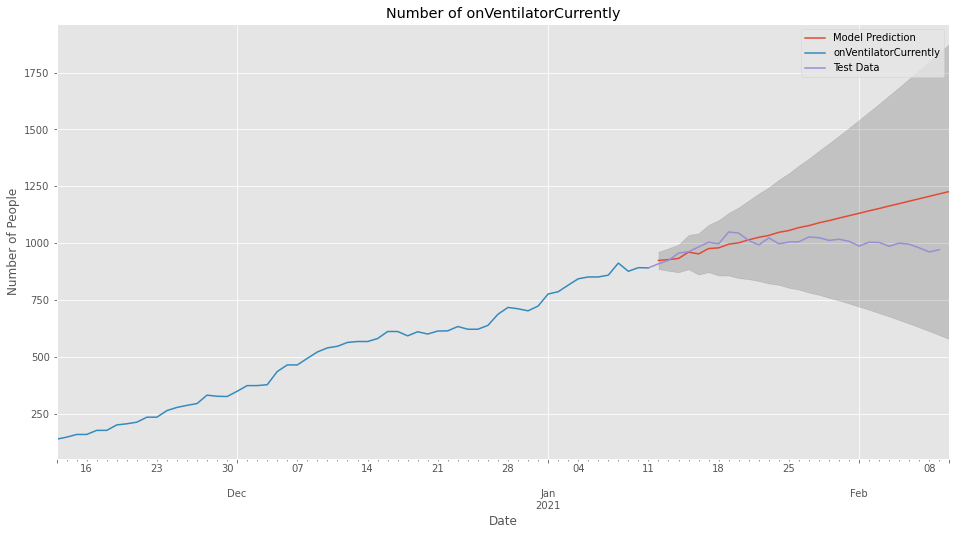

In [353]:
evaluate_predictions(results, df, 'onVentilatorCurrently', stepwise_fit=stepwise_fit, alpha=.05, days_to_forecast=30)
# plot training time and test time

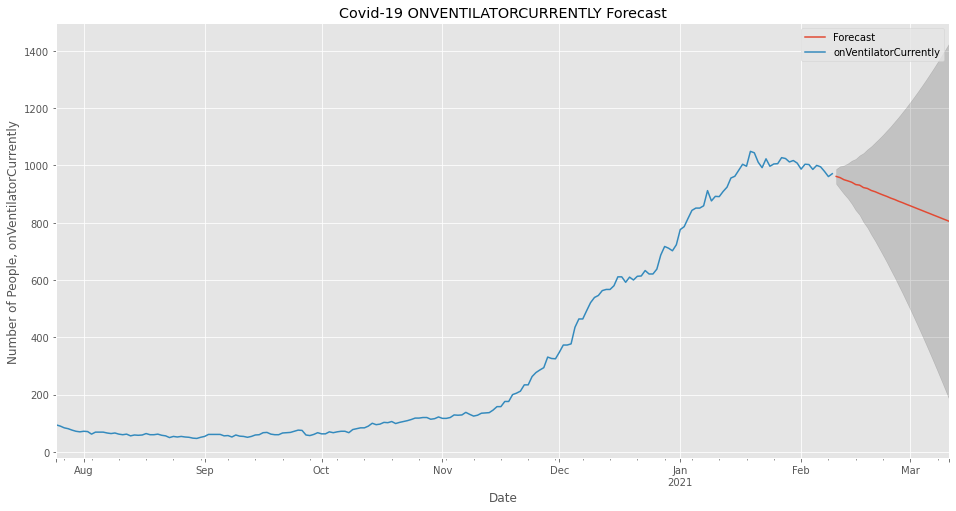

In [354]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='onVentilatorCurrently', 
                                                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                                                     alpha=.05)

### NY State Deaths Forecast

In [355]:
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='onVentilatorCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=6)

In [356]:
stepwise_fit.seasonal_order

(0, 0, 1, 6)

In [357]:
df_forecast.tail(5)

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
2021-03-07,NaN,NaN,NaN,826.410114,NaN,NaN,NaN
2021-03-08,NaN,NaN,NaN,821.070032,NaN,NaN,NaN
2021-03-09,NaN,NaN,NaN,815.600270,NaN,NaN,NaN
2021-03-10,NaN,NaN,NaN,810.214169,NaN,NaN,NaN
2021-03-11,NaN,NaN,NaN,804.786913,NaN,NaN,NaN


In [358]:
full_exog_model = SARIMAX(df['death'],df['onVentilatorCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

In [359]:
# fit model 
model = full_exog_model.fit()

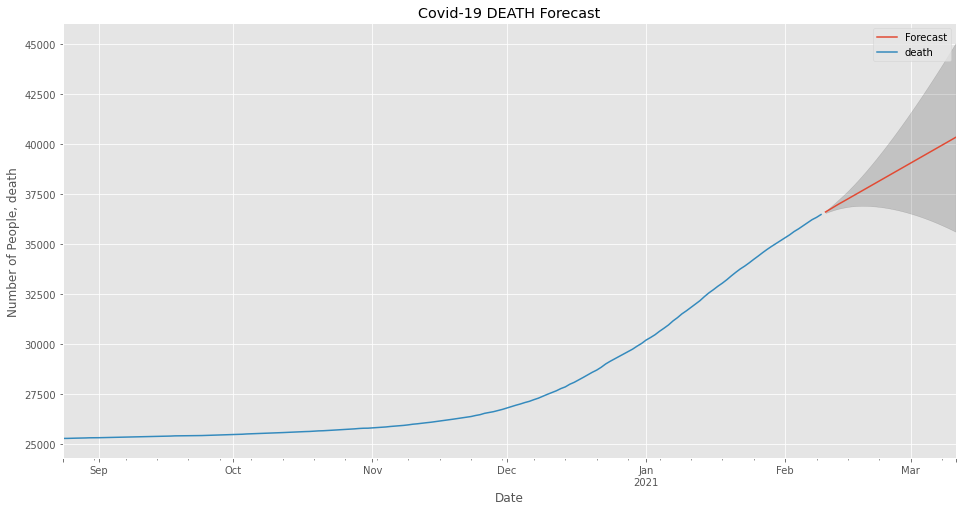

In [360]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='onVentilatorCurrently')

### Texas

#### Texas is also a populous state and also has been inclined to open back up quickly to keep the economy going. Additionally, they have not reported ICU or Ventilator numbers to the Covid Tracking Project. 

In [411]:
df = state_dataframe(df_states, 'TX')

TypeError: 'DataFrame' object is not callable

In [ ]:
df_ref = state_dataframe(df_states, 'TX')

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2020-03-03 to 2021-02-09
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  344 non-null    object 
 1   death                  344 non-null    float64
 2   inIcuCurrently         344 non-null    float64
 3   onVentilatorCurrently  344 non-null    float64
 4   positive               344 non-null    float64
 5   hospitalizedCurrently  344 non-null    float64
 6   deathIncrease          344 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 21.5+ KB


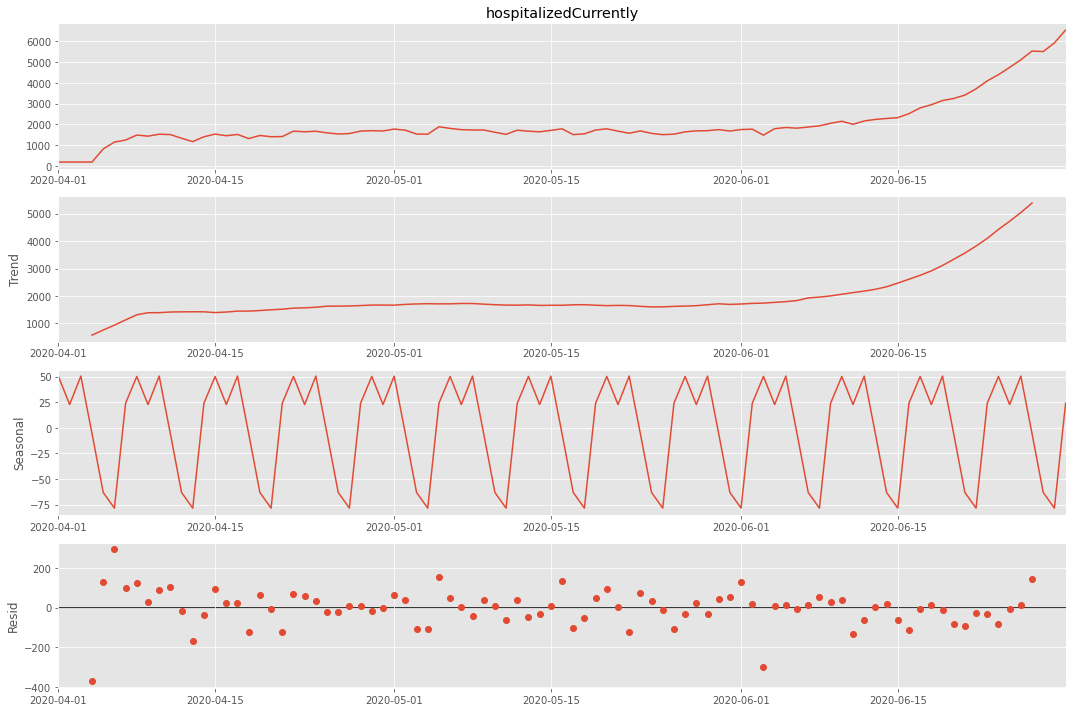

In [370]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['hospitalizedCurrently']).plot();

ARIMA order is:  (1, 1, 1)
Seasonal ARIMA order is:  (0, 0, 0, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     hospitalizedCurrently   No. Observations:                  240
Model:                  SARIMAX(1, 1, 1)   Log Likelihood               -1553.504
Date:                   Wed, 10 Feb 2021   AIC                           3113.008
Time:                           15:36:38   BIC                           3123.412
Sample:                       05-16-2020   HQIC                          3117.201
                            - 01-10-2021                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9614      0.024     40.568      0.000       0.915       1.008
ma.L1         -0.7581      0.061    -12.424      0.000      -0.878      -0.638
sigma2      2.887e+04    965.406     29.907      0.000     2.7e+04    3.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3774.69
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -2.58
Prob(H) (two-sided):                  0.17   Kurtosis:                        21.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

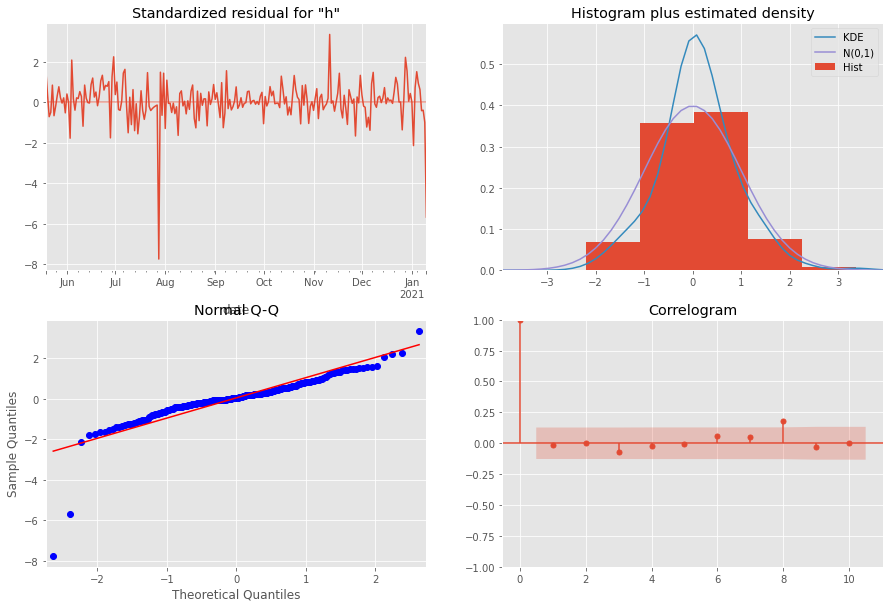

In [372]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'hospitalizedCurrently', days_to_forecast=30, m_periods=6, verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details

#### The ends of the q-q plot are not quite in line.

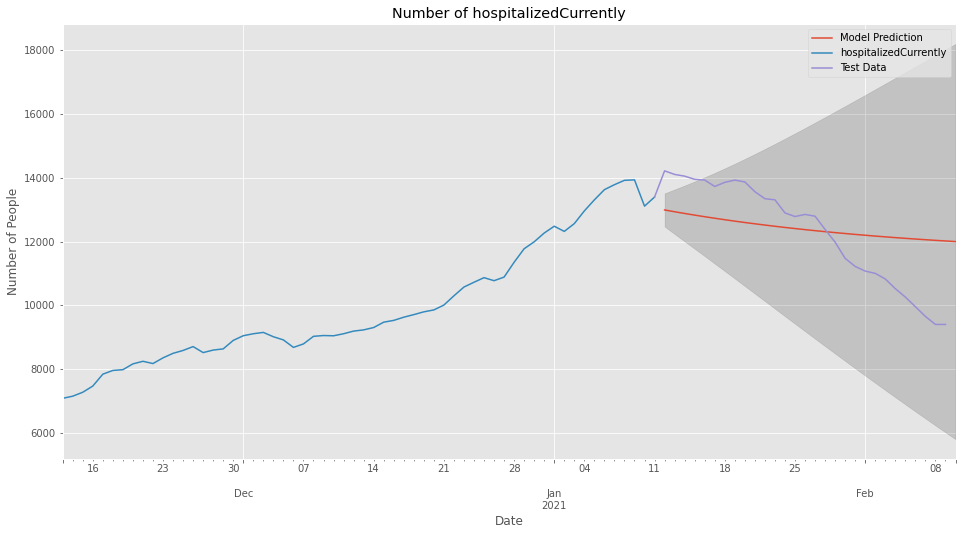

In [373]:
evaluate_predictions(results, df, 'hospitalizedCurrently', stepwise_fit=stepwise_fit, alpha=.05, days_to_forecast=30)
# plot training time and test time

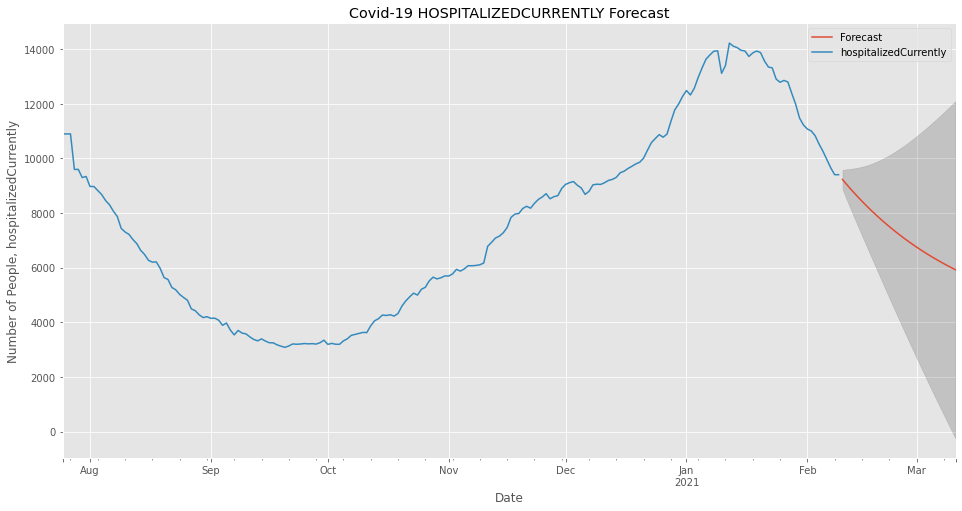

In [374]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='hospitalizedCurrently', 
                                                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                                                     alpha=.05)

### Texas Deaths Forecast

In [375]:
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='hospitalizedCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=6)

In [376]:
stepwise_fit.seasonal_order

(1, 0, 0, 6)

In [377]:
df_forecast.tail(5)

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
2021-03-07,NaN,NaN,NaN,NaN,NaN,6224.425247,NaN
2021-03-08,NaN,NaN,NaN,NaN,NaN,6145.321671,NaN
2021-03-09,NaN,NaN,NaN,NaN,NaN,6068.578809,NaN
2021-03-10,NaN,NaN,NaN,NaN,NaN,5994.126210,NaN
2021-03-11,NaN,NaN,NaN,NaN,NaN,5921.895526,NaN


In [378]:
full_exog_model = SARIMAX(df['death'],df['hospitalizedCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

In [379]:
# fit model 
model = full_exog_model.fit()

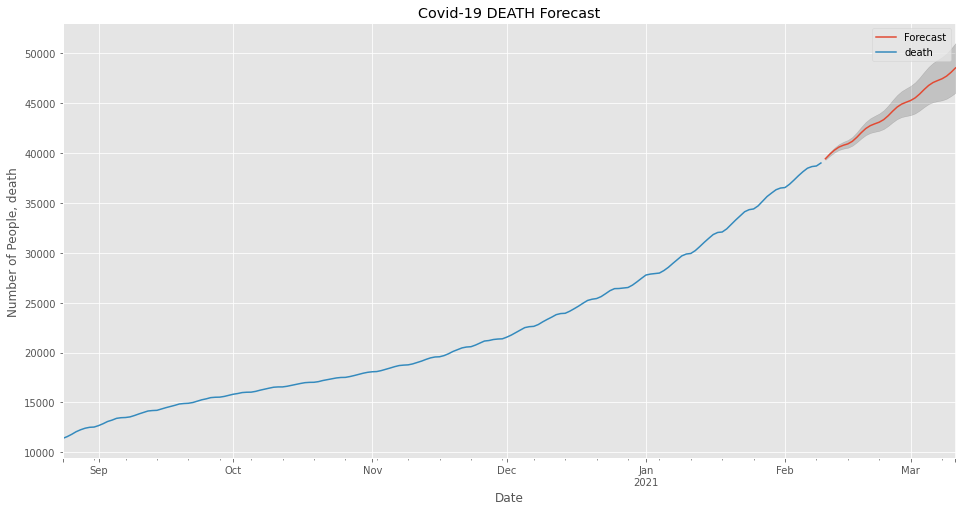

In [384]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='hospitalizedCurrently')

### California Deaths Forecast

In [407]:
df_ref = state_dataframe(df_states, 'CA')

TypeError: 'DataFrame' object is not callable

Successfully returned indexed dataframe for CA
ARIMA order is:  (5, 2, 2)
Seasonal ARIMA order is:  (2, 0, 0, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              death   No. Observations:                  240
Model:             SARIMAX(5, 2, 2)x(2, 0, [], 6)   Log Likelihood               -1186.958
Date:                            Wed, 10 Feb 2021   AIC                           2393.916
Time:                                    17:34:02   BIC                           2427.898
Sample:                                05-16-2020   HQIC                          2407.637
                                     - 01-10-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1446      0.400     -0.362      0.717      -0.928       0.639
ar.L2         -0.3048      0.094     -3.256      0.001      -0.488      -0.121
ar.L3         -0.4031      0.081     -4.986      0.000      -0.561      -0.245
ar.L4         -0.4305      0.134     -3.210      0.001      -0.693      -0.168
ar.L5         -0.3822      0.177     -2.164      0.030      -0.728      -0.036
ma.L1         -6.7188    234.085     -0.029      0.977    -465.517     452.080
ma.L2          0.8172     64.600      0.013      0.990    -125.797     127.431
ar.S.L6       -0.2632      0.151     -1.743      0.081      -0.559       0.033
ar.S.L12      -0.3399      0.097     -3.500      0.000      -0.530      -0.150
sigma2        61.8309   4288.430      0.014      0.988   -8343.337    8466.999
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               500.81
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               4.88   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

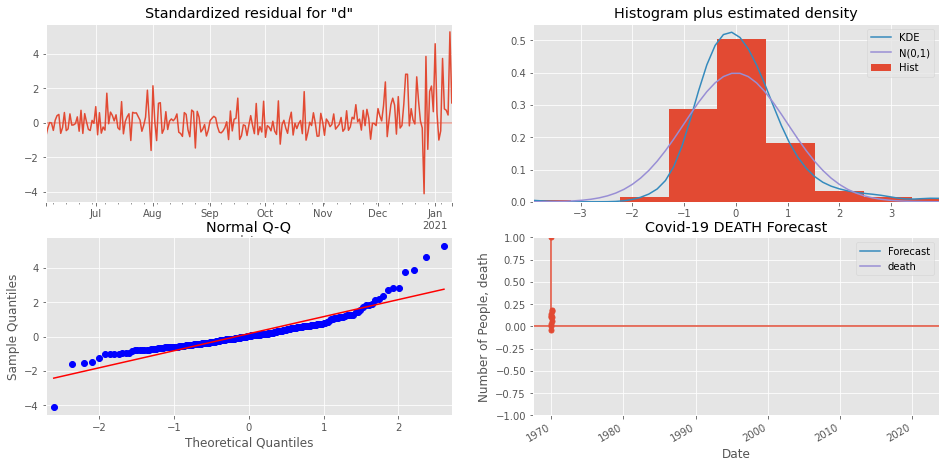

In [404]:
state_dataframe, exog_forecast = create_exog_forecast(df_states, 'hospitalizedCurrently', m_periods=7, state_postal_code='CA')

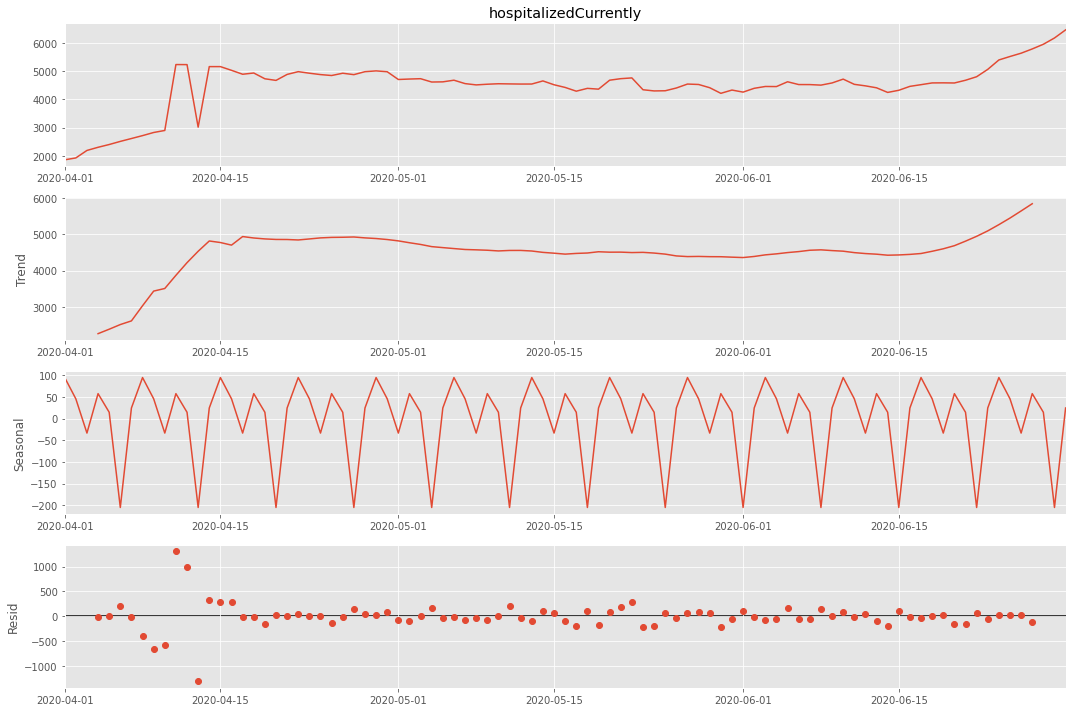

In [405]:
plt.rcParams['figure.figsize']=(15,10);
sd(state_dataframe.loc['04-2020':'06-2020']['hospitalizedCurrently']).plot();

In [406]:
graph_exog_forecast(dataframe=state_dataframe, 
                    target_column='death', 
                    exogenous_column='hospitalizedCurrently', 
                    exog_forecast=exog_forecast,
                    df_ref=df_ref, 
                    alpha=.05, days_to_forecast=30, 
                    train_days=270, m_periods=7)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# combine all functions into one that will output a forecast. 

In [70]:
# questions and analysis

In [ ]:
# README.md

In [72]:
# put together slides, non-technical presentation

In [73]:
# provide further notes in appendix style for univariate and multivariate NN forecasting

### Alaska SARIMA Model

In [ ]:
df_AK = df_AK.sort_index()

In [ ]:
df_AK = df_AK.dropna(subset=['death'])
df_AK = df_AK.dropna(subset=['onVentilatorCurrently'])

In [ ]:
df_alaska = pd.DataFrame(df_AK)

In [ ]:
print(df_alaska.index.min())
print(df_alaska.index.max())
print('Length of dataframe: ' , len(df_alaska))

In [ ]:
sd(df_alaska['death'], model='additive').plot(); # alaska = seasonal

In [ ]:
stepwise_fit = auto_arima(df_alaska['death'],start_p=0,start_q=0,max_p=10,
                          max_q=10, seasonal=True, seasonal_test='ocsb', maxiter=75, method='lbfgs',
                          n_jobs=-1,stepwise=True)

In [ ]:
model = SARIMAX(df_alaska['death'], order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order).fit()
model.summary()

In [ ]:
# dont forget get_predict
predictions_AK = model.get_forecast(30)

In [ ]:
predictions_AK.predicted_mean

In [ ]:
predictions_AK.predicted_mean
predictions_AK.conf_int(alpha=.05) # lower and upper confidence intervals, 
# phase4 appendix will tell you how to graph and shade in between these two plots

# # Get forecast 500 steps ahead in future
# prediction = output.get_forecast(steps=500)

# # Get confidence intervals of forecasts
# pred_conf = prediction.conf_int()

# ax = CO2.plot(label='observed', figsize=(20, 15))
# prediction.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='k', alpha=0.25)
# ax.set_xlabel('Date')
# ax.set_ylabel('CO2 Levels')

# plt.legend()
# plt.show()

In [ ]:
stepwise_fit.order

In [ ]:
stepwise_fit.summary()

In [ ]:
length = len(df_alaska)-45

In [ ]:
train_data = df_alaska.iloc[:length]
test_data = df_alaska.iloc[length:]

In [ ]:
train_data

In [ ]:
test_data

In [ ]:
model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

In [ ]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [ ]:
predictions_AK = res.predict(start,end,typ='endogenous').rename('SARIMAX(0,2,1) Predictions')

In [ ]:
train_data.index

In [ ]:
test_data.index

In [ ]:
predictions_AK = pd.DataFrame(predictions_AK)

In [ ]:
predictions_AK.index.name = 'date'

#### Compare Test Data with Predictions

In [ ]:
train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

In [ ]:
pd.DataFrame(test_data['death']).info()

In [ ]:
predictions_AK.info()

In [ ]:
pd.DataFrame(test_data['death']).plot(figsize=(16,8),legend=True,title='Test Data vs SARIMA',grid=True)
plt.plot(pd.DataFrame(predictions_AK))
plt.show()

In [ ]:
model = sm.tsa.statespace.SARIMAX(df_alaska['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

In [ ]:
fcast = res.predict(start=len(df_AK),end=len(df_AK)+45, typ='endogenous').rename('SARIMAX FORECAST')

In [ ]:
fig, ax = plt.subplots()

train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',title='Forecast Deaths, Alaska',grid=True);
test_data['death'].plot(grid=True);
fcast.plot(legend=True,figsize=(18,8)); 
ax.grid();
plt.show();

In [ ]:
fig, ax = plt.subplots()

test_data['death'].plot(figsize=(16,8),legend=True,title='Forecast Deaths, Alaska',grid=True);
train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',grid=True);
plt.plot(pd.DataFrame(predictions_AK)); # 'FORECAST' FROM END OF TRAINING DATA
fcast.plot(legend=True,figsize=(18,8)); # SARIMA FORECAST
ax.grid();
plt.show();

### Dashboard Dev, Work in Progress

In [ ]:
# ## getting S&P500 symbols
# import requests
# url= 'https://api.covidtracking.com/v1/states/daily.csv'
# response = requests.get(url)
# response.status_code

In [ ]:
# response.

In [ ]:
# def summary_states(df_states,state_postal_code,days):
    
#     '''
#     *purpose: creates a SARIMA model based on datetime dataframe with column 'death'
#               and a state postal code under column 'state'
    
#     *inputs:
#     df_states: a dataframe of the state Covid data
#     state_postal_code: state postal code to get state related death data
#     days: number of days out you wish to forecast
#     '''
#     # create dataframe based on state_postal_code
#     df_state = df_states[df_states['state']==state_postal_code]    

#     # sort index, lowest index to oldest date, drop na's in death column
#     df_state = df_state.sort_index()
#     df_state = df_state.dropna(subset=['death'])
#     df_state_new = pd.DataFrame(df_state)

#     # create stepwise fit model, see summary
#     stepwise_fit = auto_arima(df_state_new['death'],start_p=0,start_q=0,max_p=10,
#                               max_q=10, seasonal=True, maxiter=1000, method='bfgs',
#                               n_jobs=-1,stepwise=True) 

#     # auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
#     ## find correct ARIMA order

#     arima_order = stepwise_fit.order

#     length = len(df_state_new)-days

#     df_actuals = df_state_new
#     train_data = df_state_new.iloc[:length]
#     test_data = df_state_new.iloc[length:]

#     model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=arima_order)
#     res = model.fit(disp=False)

#     start = len(train_data)
#     end = len(train_data) + len(test_data) - 1

#     predictions_state = res.predict(start,end,typ='endogenous').rename(f'SARIMA{arima_order} Predictions')

#     # ensure predictions are in DataFrame format, label index as date to match df_alaska
#     # predictions_state = pd.DataFrame(predictions_state)
#     predictions_state.index.name = 'date'

#     train_data.index.freq = 'D'
#     test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
#     # perform sort_index on dataframe to correct. set frequencies to match for plotting
#     # on same visualization

#     # graph test vs. prediction data - {PLOT}
#     legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
#                        Line2D([0], [0], color='r', lw=4, label=f'SARIMA{arima_order} Predictions')]

#     fig, ax = plt.subplots(figsize=(20,10));
#     ax.plot(test_data['death'])
#     ax.plot(predictions_state);
#     ax.grid(b=True,alpha=.5)
#     plt.title(f'Test Data vs SARIMA, {state_postal_code}')
#     ax.legend(handles=legend_elements)
#     plt.xlabel('Date')
#     plt.ylabel('Deaths')
#     plt.show();

#     # train model for forecast
#     model = sm.tsa.statespace.SARIMAX(df_state['death'],trend='ct', order=arima_order)
#     res = model.fit(disp=False)

#     # create forecast
#     fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days, typ='endogenous').rename(f'SARIMA{arima_order} {days} Days Forecast')

#     # graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
#     legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
#                        Line2D([0], [0], color='r', lw=5, label='Actual Deaths'),
#                        Line2D([0], [0], color='y', lw=5, label=f'SARIMA{arima_order} Predictions'),
#                        Line2D([0], [0], color='g', lw=5, label=f'SARIMA{arima_order} {days} Day Forecast')]

#     fig, ax = plt.subplots(figsize=(20,10));
#     ax.plot(train_data['death'])
#     ax.plot(test_data['death'])
#     ax.plot(predictions_state)
#     ax.plot(fcast)
#     ax.grid(b=True,alpha=.5)
#     plt.title(f'SARIMA {days} Day Forecast, {state_postal_code}')
#     ax.legend(handles=legend_elements)
#     plt.xlabel('Date')
#     plt.ylabel('Deaths')
#     plt.show();
    
#     return df_actuals
#     return fcast # returning fcast to put into plot_forecast

In [ ]:
# summary_states(df_states,'CA',30)

In [ ]:
# def plot_forecast(df,states=[]):
#     if len(states)==0:
#         states=None
#     pfig = px.line(df)
#     return pfig

In [ ]:
# def make_options(menu_choices,ignore_cols=['Date']):
#     """Returns list of dictionary with {'label':menu_choice,'value':menu_choice}"""
#     options = []
#     for choice in menu_choices:
#         if choice not in ignore_cols:
#             options.append({'State':choice,'Postal Code':choice})
#     return options

# state_options = make_options(state_postal)
# make_options(state_postal)

In [ ]:
# pio.templates.default = "plotly_dark"

In [ ]:
# df_state = df_states[df_states['state']=='CA']    

# # sort index, lowest index to oldest date, drop na's in death column
# df_state = df_state.sort_index()
# df_state = df_state.dropna(subset=['death'])
# df_actuals = pd.DataFrame(df_state)
    
# ## App here
# app = JupyterDash('App2')

# app.layout = html.Div(children=[
#     html.H1('Forecasting'),
#     html.H2('COVID-19 Deaths Forecast'),
#     dcc.Dropdown(id='states',options=state_options,multi=True),
#     dcc.Graph(id=f'{state}',figure=plot_forecast(df_actuals['death'],fcast))])
# app    

# @app.callback(Output('states','figure'),
#               [Input(f'{state}','value')])

# def update_forecast(states,state):
#     return plot_forecast(df_states[f'{state}'])
# app

In [ ]:
# today = dt.date.today().strftime("%Y-%m-%d")

# def get_data(start_date=df_states,end_date=today,state_codes=state_postal_code):
    
#     data = {}
#     for state in state_codes:
#         try:
#             data[state] = pdr.DataReader(df_states,'yahoo',start_date,end_date)['death']
#         except:
#             print('Error with stock: '+stock)
#     df = pd.DataFrame(data).reset_index()
#     return df


# def plot_forecast_df(df=None,stocks=['FB','AAPL']):
#     if df is None:
#         df = get_data(stocks)#.reset_index()
#     stocks_exist = [s for s in stocks if s in df.columns]
#     pfig = px.scatter(df,x='Date',y=stocks_exist)
#     return pfig

# from jupyter_plotly_dash import JupyterDash
# app = JupyterDash('Example', 
#                   serve_locally=False)
# defaults = ['MSFT','AMZN']
# # df = get_data(date(2012, 1, 1))

# app.layout = html.Div(children = [
#     html.H1('Our AMAZING Dashboard'),
    
#     html.Div(children=[
#         html.Div(style={"border":'1px solid black','padding':'3px'},id='menu',children=[
#             html.H3('Enter state postal codes, separated by a comma.\nPress Enter to update.'),

#             dcc.Input(id='choose_stocks',value='MSFT,AMZN',
#                       placeholder='MSFT,AAPL',#,
#                          style={'width': '90%', 'height': 50}),           

#             dcc.DatePickerRange( id='my-date-picker-range',
#                                 start_date=date(2012,1,1),
#                                 min_date_allowed=date(2010, 1, 1),
#                                 max_date_allowed=today,#date.today(),#date(2021),
#                                 end_date=today,style={'width':'50%'}),#date.today()), #date(2017, 8, 25)),
#             html.Button('Submit',id='submit',style={'size':'40 px'})
    
#         ]),
        
#         dcc.Graph(id='line_plot')

#     ])
# ])

# @app.callback(Output('line_plot','figure'),
#               [Input('submit','n_clicks')],
#               [State('choose_stocks','value'),
#                State('my-date-picker-range', 'start_date'),
#                State('my-date-picker-range', 'end_date')])
# def update_stocks(n_clicks, stocks,start_date,end_date):
#     stocks = stocks.split(',')
#     plot_df = get_data(start_date,end_date,symbols=stocks)
#     return plot_stocks_df(df=plot_df,stocks=stocks)#,start_date,end_date)
    
# app

In [ ]:
# data = {}
# days = 20

# for state in state_postal:
#     cas_state(df_states,state,days)

### Forecast by State, SARIMA

#### Here, provide DataFrame, postal code, and number of days in the future you wish to forecast. Code for this function is in Python file, Cust_Func.py

### Alaska

In [ ]:
cas_state(df_states=df_states, state_postal_code='AK',days=35)

#### Based on a 35 day forecast as of data pulled on 01-24-2021 and good thru 01-23-2021, Alaska is seeing an increase in death rate. As of mid-December, the trend was flatter than the forecasted trend. Deaths currently sit at just over 250, but are projected to reach over 400 by the beginning of March. 

## Univariate Forecast with RNN

### Texas

In [ ]:
create_nn(df_states=df_states,state_postal_code='TX',days=25,epochs=4) # 

### Florida

In [ ]:
create_nn(df_states,'FL',20,epochs=4)

### California

In [ ]:
create_nn(df_states,'CA',20,epochs=4)

## Using an Exogenous Variable with SARIMAX

### pdq SARIMAX build

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = [0,1,2]

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(alaska_df['death'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
arima_order = ans_df['pdq'].loc[ans_df['aic'].idxmin()]
seasonal_arima = ans_df['pdqs'].loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_alaska['death'],
                                        exogenous=df_alaska['ventilator_forecast']
                                        order=arima_order, 
                                        seasonal_order=seasonal_arima, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# adding holidays into dataframe below

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

calendar = calendar()
holidays = calendar.holidays(start=df_states.index.min(), end=df_states.index.max())

df_states['holiday'] = df_states.index.isin(holidays)

df_whole_US['holiday'] = df_whole_US.index.isin(holidays)

In [ ]:
df_states = clean_df(df_states,.05)

In [ ]:
state_postal_code = 'TX'
days = 30

df_state = df_states[df_states['state']==state_postal_code]    

# sort index, lowest index to oldest date, drop na's in death column
df_state = df_state.sort_index()
df_state = df_state.dropna(subset=['death'])
df_state_new = pd.DataFrame(df_state)

#     ets_decomp = sd(df_state_new['death'])
#     ets_decomp.plot();

# create stepwise fit model, see summary
stepwise_fit = auto_arima(df_state_new['death'],seasonal=True,m=52,maxiter=2)

# auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
## find correct ARIMA order

arima_order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order

length = len(df_state_new)-days

train_data = df_state_new.iloc[:length]
test_data = df_state_new.iloc[length:]

model = sm.tsa.statespace.SARIMAX(train_data['death'], trend='ct', seasonal_order=seasonal_order, 
                                  order=arima_order, enforce_invertibility=False)
res = model.fit()

start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions_state = res.predict(start,end,dynamic=False).rename(f'SARIMAX {arima_order} Predictions')

# ensure predictions are in DataFrame format, label index as date to match df_alaska
predictions_state = pd.DataFrame(predictions_state)
predictions_state.index.name = 'date'

train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

# graph test vs. prediction data - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=4, label=f'SARIMAX {arima_order} Predictions')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(test_data['death'])
ax.plot(predictions_state);
ax.grid(b=True,alpha=.5)
plt.title(f'Test Data vs SARIMA, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in test_data.index:
    if test_data['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

error1 = mse(test_data['death'], predictions_state)
error2 = rmse(test_data['death'], predictions_state)

# print(f'SARIMAX{arima_order}{seasonal_order} MSE Error: {error1}')
# print(f'SARIMAX{arima_order}{seasonal_order} RMSE Error: {error2}')

# train model for forecast
model = sm.tsa.statespace.SARIMAX(df_state_new['death'],exog=df_state_new['holiday'],
                                  order=arima_order, seasonal_order=seasonal_order,
                                  enforce_invertibility=False)
res = model.fit(disp=False)

# create forecast
exog_forecast = df_state_new[length:][['holiday']]
fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days-1,exog=exog_forecast).rename(f'SARIMAX{arima_order},{seasonal_order} {days} Days Forecast')

# graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='g', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} Predictions'),
                   Line2D([0], [0], color='r', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} {days} Day Forecast')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(train_data['death'])
ax.plot(test_data['death'])
ax.plot(predictions_state)
ax.plot(fcast)
ax.grid(b=True,alpha=.5)
plt.title(f'SARIMAX {days} Day Forecast, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in df_state_new.index:
    if df_state_new['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

last_predictions = len(fcast)-5
actual_numbers = fcast[last_predictions:]

return actual_numbers

### Texas

In [ ]:
create_SAX(df_states,'TX',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting Texas deaths at 44,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### California

In [ ]:
create_SAX(df_states,'CA',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting California deaths at 51,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### Florida

In [ ]:
create_SAX(df_states,'FL',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting Florida deaths at over 30,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### All States

In [ ]:
create_SAX_usa(df_whole_US,25)

## Multivariate Forecast with RNN

### Data Import and Ventilator/Death Plot

In [ ]:
# initialize Df
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

In [ ]:
# we can see some lag here, common sense tells us we will probably see a 
#decrease in death rate after ICU and Ventilator populations fall. 
df_whole_US['inIcuCurrently'].plot(legend=True, figsize=(15,7))
df_whole_US['onVentilatorCurrently'].plot(legend=True, figsize=(15,7))
(df_whole_US['death']/10).plot(legend=True);  # to scale to other graphs

In [ ]:
mv_forecast(df_whole_US,days_to_train=50,days_to_forecast=20,epochs=100) 
#hyperparameters to optimize days to train?

In [ ]:
# right now deaths is running total, in icu currently is the current value. utility
# slash usefulness are slightly different.
# currently indicates pressure on the healthcare system

# Feed in a ventilator forecast into the exogenous SARIMAX functions to
# improve the modeling while adding sophistication. make this and return this
# in a separate function. 

## Questions

### Question 1

### Question 2

### Question 3

## Conclusions

## Future Work